In [2]:
# ПОДКЛЮЧЕНИЕ БИБЛИОТЕК
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from pathlib import Path

In [3]:
#создание папки для графиков
p = Path.cwd()
d = p / 'charts'
d.mkdir(exist_ok=True)

In [4]:
#обращение к файлу с исходными данными
load_dotenv()
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [5]:
#обработка визитов
vis = requests.get(f'{API_URL}/visits?', params={'begin': DATE_BEGIN, 'end': DATE_END}) #мб косяк с адресом
df_vis = vis.json() #перевод в JSON
df_vis=pd.DataFrame(df_vis) #перевод JSON в DataFrame

In [6]:
#обработка регистраций
reg = requests.get(f'{API_URL}/registrations?', params={'begin': DATE_BEGIN, 'end': DATE_END})
df_reg = reg.json() #перевод в JSON
df_reg=pd.DataFrame(df_reg) #перевод JSON в DataFrame

In [7]:

#фильтрация и группировка визитов
df_vis['visit_dt'] = pd.to_datetime(df_vis['datetime'])
df_vis = df_vis.sort_values(by=['visit_id', 'visit_dt']).drop_duplicates(subset='visit_id', keep='last')
df_vis = df_vis[~df_vis['platform'].str.contains('bot')]
df_vis['date_group'] = df_vis['visit_dt'].dt.to_period('D').dt.start_time.dt.date
df_vis_result = df_vis.groupby(['date_group', 'platform']).size().reset_index(name='visits')

In [8]:
#фильтрация и группировка регистраций
df_reg['platform']= df_reg['platform'].fillna('web')
df_reg['registration_dt'] = pd.to_datetime(df_reg['datetime'])
df_reg['date_group']=df_reg['registration_dt'].dt.to_period('D').dt.start_time.dt.date
df_reg_result=df_reg.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

In [9]:
#расчет конверсий
vis_reg_conversion=pd.merge(df_vis_result, df_reg_result, on=['date_group', 'platform'])
vis_reg_conversion['conversion'] = (
    vis_reg_conversion['registrations'] / vis_reg_conversion['visits'] * 100
)
vis_reg_conversion.to_json('conversion.json')

In [10]:
#обработка файла с данными рекламы
df_ads = pd.read_csv('./ads.csv')
df_ads = df_ads.drop_duplicates()
df_ads['date'] = pd.to_datetime(df_ads['date'], format='mixed')
df_ads['date'] = df_ads['date'].dt.to_period('D').dt.start_time.dt.date
df_ads = df_ads.rename(columns={'date': 'date_group'})
df_ads['utm_campaign'] = df_ads['utm_campaign'].fillna('none')
df_ads['cost'] = pd.to_numeric(df_ads['cost'], errors='coerce').fillna(0)

In [11]:
DATE_BEGIN = pd.to_datetime(DATE_BEGIN).date()
DATE_END = pd.to_datetime(DATE_END).date()
filtered_df=df_ads[(df_ads['date_group'] >= DATE_BEGIN) & (df_ads['date_group'] <= DATE_END)]
ads_result = (
    filtered_df
    .groupby(['date_group', 'utm_campaign'])['cost']
    .sum()
    .reset_index()
)

In [12]:
result_ads = pd.merge(
vis_reg_conversion, ads_result,
left_on='date_group',
right_on='date_group',
how='left')
result_ads.loc[result_ads['utm_campaign'].isnull(), 'utm_campaign'] = 'none'
result_ads = result_ads.sort_values(by='date_group', ascending=True)
result_ads = result_ads[['date_group', 'platform', 'visits', 'registrations', 'conversion', 'cost', 'utm_campaign']]
result_ads.to_json('ads.json')

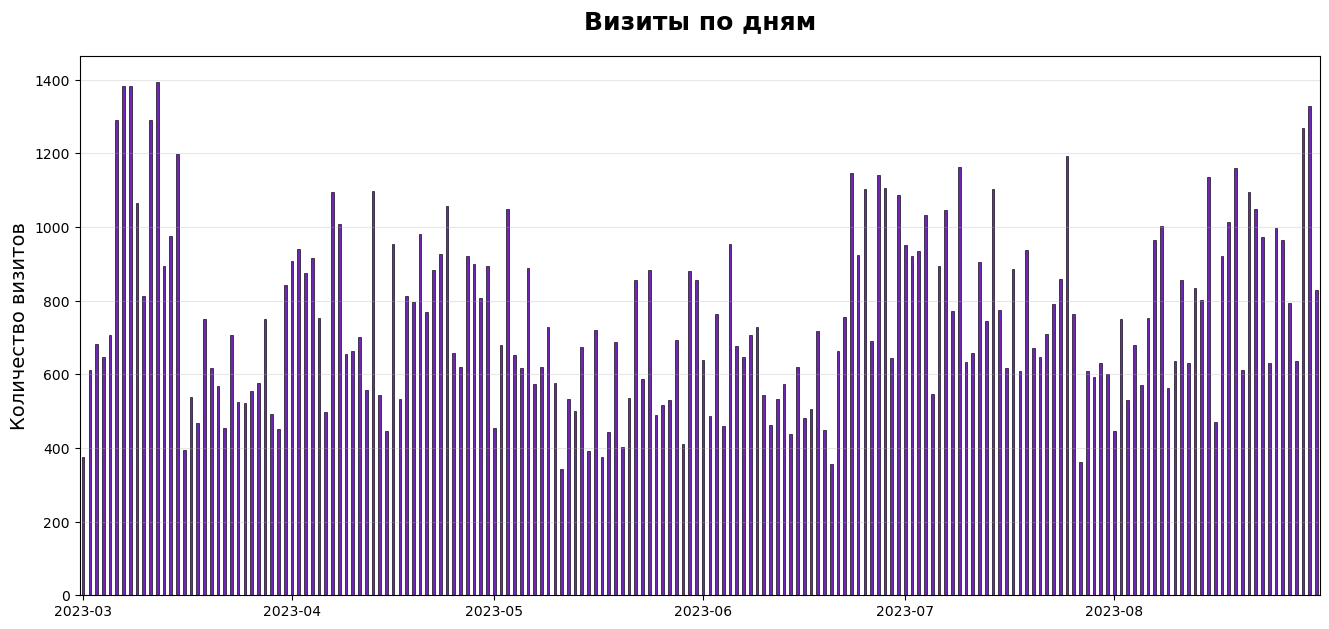

In [13]:
# Визиты по дням
visits_by_day = result_ads.copy()
visits_by_day['date_readable'] = pd.to_datetime(visits_by_day['date_group']).dt.normalize()
visits_by_day = visits_by_day.groupby('date_readable')['visits'].sum().reset_index()
visits_by_day['date_plot'] = pd.to_datetime(visits_by_day['date_readable'], format='%Y-%m-%d')

plt.figure(figsize=(16, 7))
bars = plt.bar(
    visits_by_day['date_plot'],
    visits_by_day['visits'],
    width=0.4,                
    alpha=0.9,
    color='#600ead',           
    edgecolor='black',
    linewidth=0.5
)
plt.title('Визиты по дням', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('', fontsize=14)
plt.ylabel('Количество визитов', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xlim(
    visits_by_day['date_plot'].min() - pd.Timedelta(days=0.5),
    visits_by_day['date_plot'].max() + pd.Timedelta(days=0.5)
)
plt.savefig( d / 'final_visits.png', dpi=300, bbox_inches='tight')

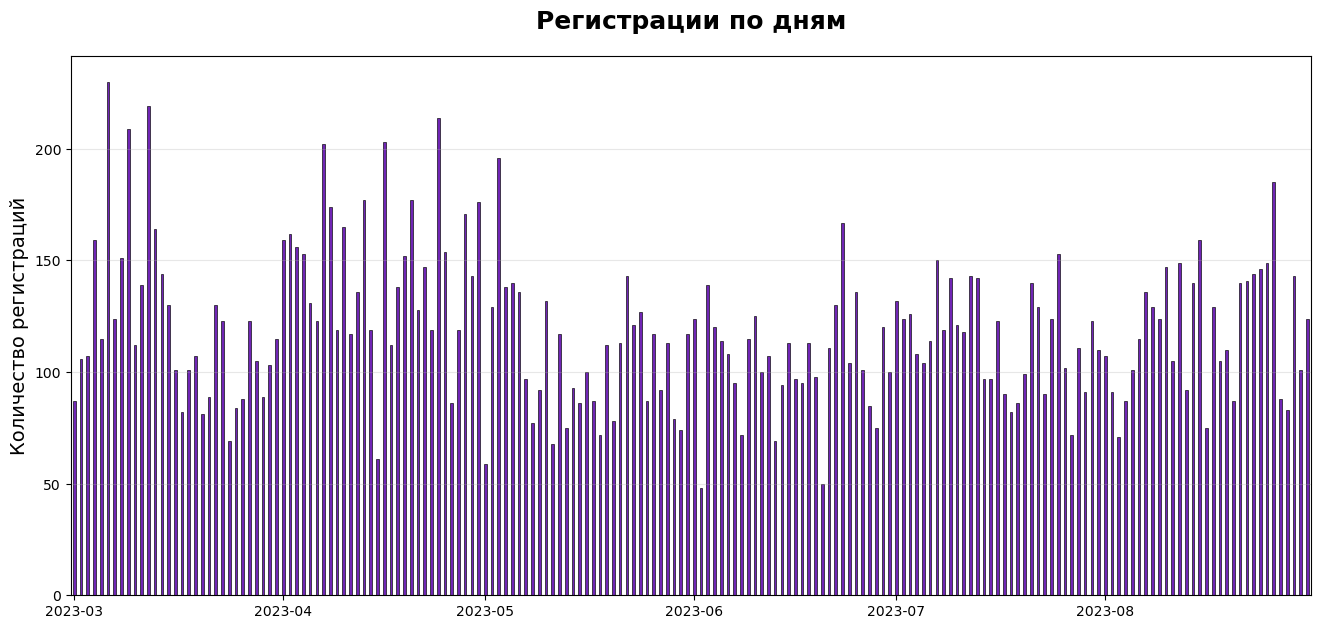

In [14]:
# Регистраций по дням
reg_by_day = result_ads.copy()
reg_by_day['date_readable'] = pd.to_datetime(reg_by_day['date_group']).dt.normalize()
reg_by_day = reg_by_day.groupby('date_readable')['registrations'].sum().reset_index()
reg_by_day['date_plot'] = reg_by_day['date_readable']
reg_by_day['date_plot'] = pd.to_datetime(
    reg_by_day['date_readable'],
    format='%Y-%m-%d'
)


plt.figure(figsize=(16, 7))
bars = plt.bar(
    reg_by_day['date_plot'],
    reg_by_day['registrations'],
    width=0.4,                
    alpha=0.9,
    color='#600ead',           
    edgecolor='black',
    linewidth=0.5
)
plt.title('Регистрации по дням', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('', fontsize=14)
plt.ylabel('Количество регистраций', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xlim(
    visits_by_day['date_plot'].min() - pd.Timedelta(days=0.5),
    visits_by_day['date_plot'].max() + pd.Timedelta(days=0.5)
)
plt.savefig( d / 'final_reg.png', dpi=300, bbox_inches='tight')

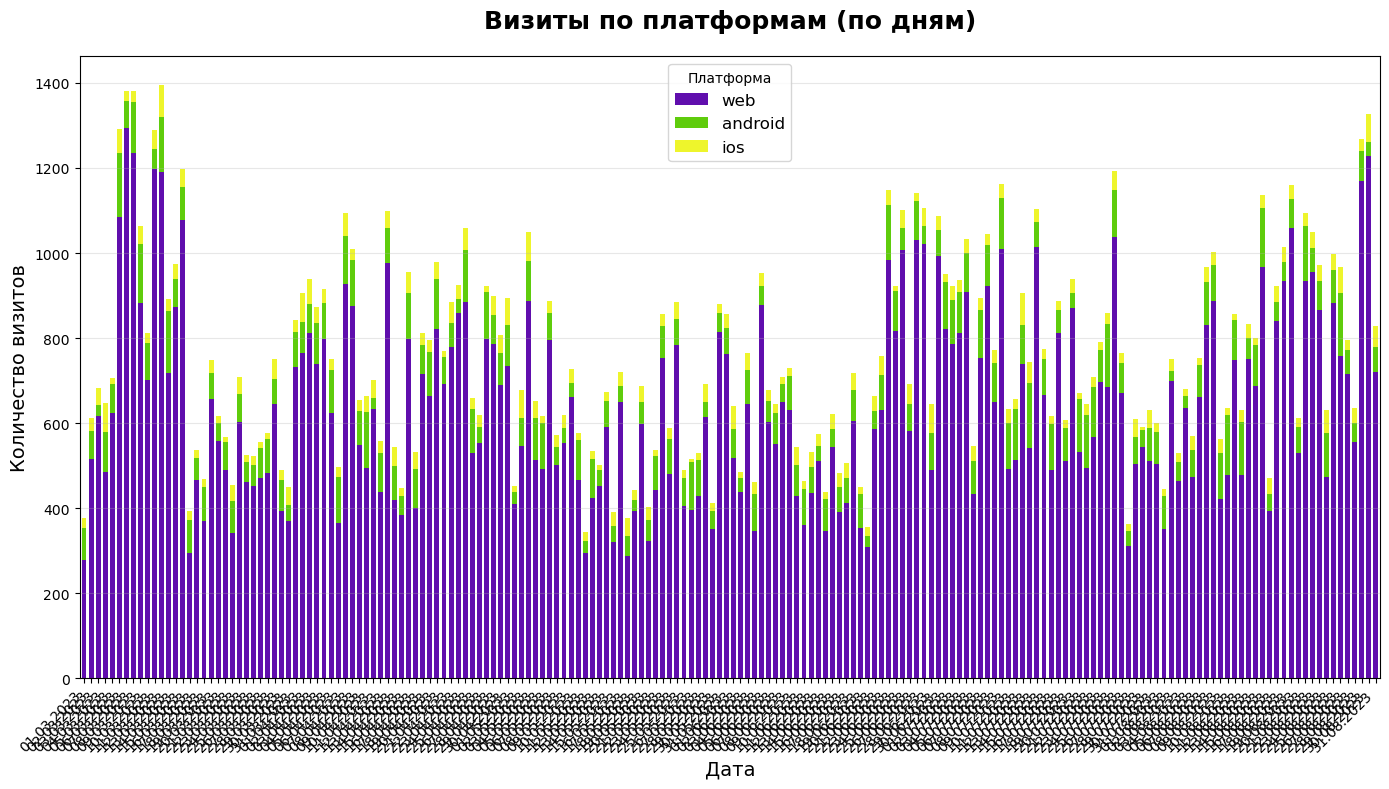

In [15]:
# визиты по платформам
visits_platform = result_ads.copy()
visits_platform['date_readable'] = pd.to_datetime(
    visits_platform['date_group'],
    format='%Y-%m-%d'
).dt.normalize()
platforms = ['web', 'android', 'ios']
filtered_result = visits_platform[visits_platform['platform'].isin(platforms)]
visits_by_day_platform = (
    filtered_result
    .groupby(['date_readable', 'platform'])['visits']
    .sum()
    .unstack(fill_value=0)  
    [platforms]
)
plt.figure(figsize=(14, 8))
colors = ['#600ead', '#5fcc0c', '#eef52c']  # web, android, ios
bars = visits_by_day_platform.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=plt.gca(),
    width=0.7
)
plt.title('Визиты по платформам (по дням)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество визитов', fontsize=14)
plt.legend(title='Платформа', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(
    ticks=range(len(visits_by_day_platform.index)),
    labels=[d.strftime('%d.%m.%Y') for d in visits_by_day_platform.index],
    rotation=45,
    ha='right'
)
plt.tight_layout()
plt.savefig( d / 'visits_platform.png', dpi=300, bbox_inches='tight')

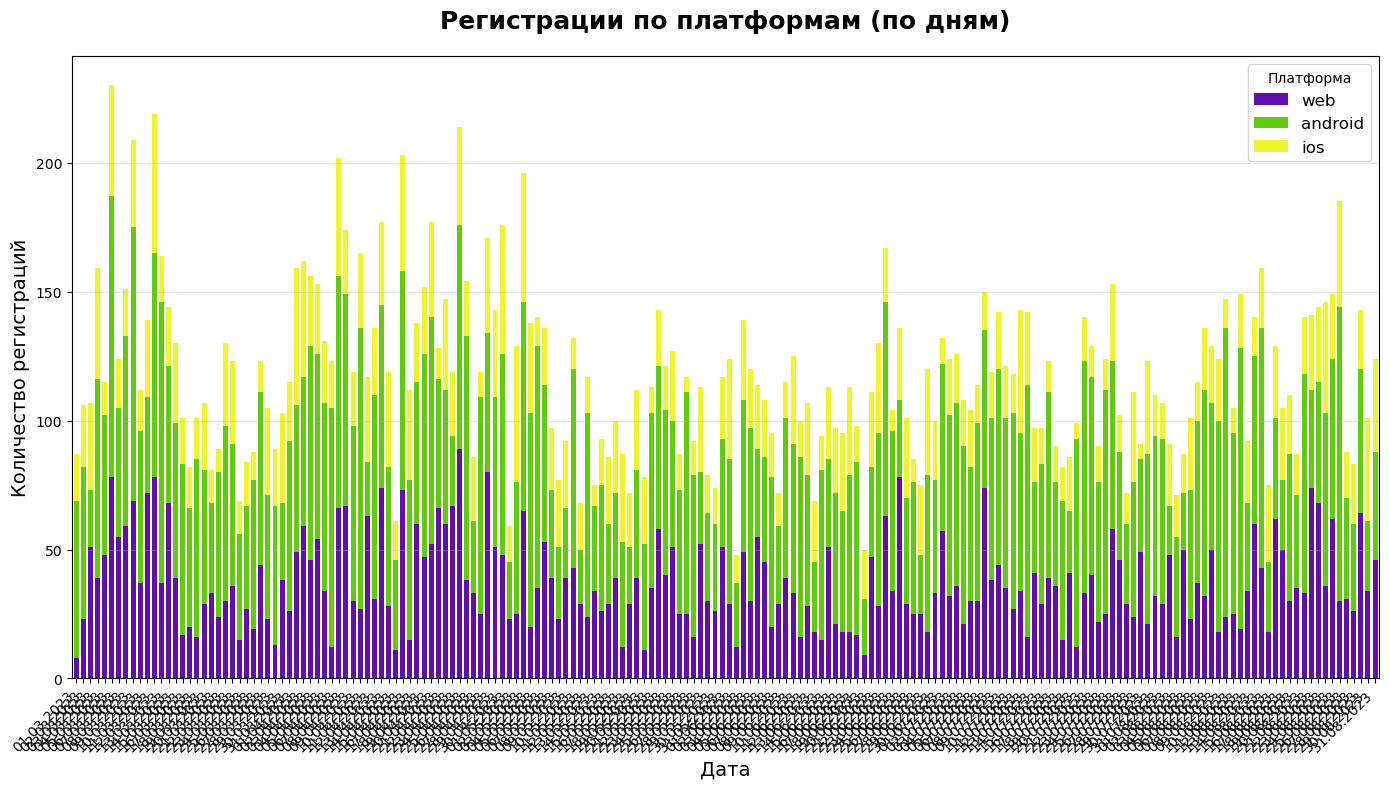

In [16]:
# регистрации по платформам
reg_platform = result_ads.copy()
reg_platform['date_readable'] = pd.to_datetime(
    reg_platform['date_group'],
    format='%Y-%m-%d'
).dt.normalize()


platforms = ['web', 'android', 'ios']
filtered_result = reg_platform[reg_platform['platform'].isin(platforms)]
reg_by_day_platform = (
    filtered_result
    .groupby(['date_readable', 'platform'])['registrations']
    .sum()
    .unstack(fill_value=0)  
    [platforms]
)
plt.figure(figsize=(14, 8))
colors = ['#600ead', '#5fcc0c', '#eef52c']  # web, android, ios
bars = reg_by_day_platform.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=plt.gca(),
    width=0.7
)
plt.title('Регистрации по платформам (по дням)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество регистраций', fontsize=14)
plt.legend(title='Платформа', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(
    ticks=range(len(reg_by_day_platform.index)),
    labels=[d.strftime('%d.%m.%Y') for d in reg_by_day_platform.index],
    rotation=45,
    ha='right'
)
plt.tight_layout()
plt.savefig( d / 'reg_platform.png', dpi=300, bbox_inches='tight')

In [ ]:
# накопительная конверсия по платформам
daily_conversion = result_ads.copy()
daily_conversion['date_readable'] = pd.to_datetime(
    daily_conversion['date_group'],
    format='%Y-%m-%d'
).dt.normalize()
platforms = ['web', 'android', 'ios']
filtered_result = daily_conversion[daily_conversion['platform'].isin(platforms)]
daily_conversion_by_platform = (
    filtered_result
    .groupby(['date_readable', 'platform'])['conversion']
    .mean() 
    .unstack(fill_value=0)
    [platforms]  
)
plt.figure(figsize=(14, 7))
colors = ['#600ead', '#5fcc0c', '#eef52c']  # web, android, ios
bars = daily_conversion_by_platform.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=plt.gca(),
    width=0.7
)
plt.title('Накопительная конверсия по платформам (по дням)', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Конверсия (%)', fontsize=12)

plt.legend(title='Платформа', fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.xticks(
    ticks=range(len(daily_conversion_by_platform.index)),
    labels=[d.strftime('%d.%m.%Y') for d in daily_conversion_by_platform.index],
    rotation=45,
    ha='right'
)
plt.tight_layout()
plt.savefig( d / 'conversion_platform.png', dpi=300, bbox_inches='tight')

In [ ]:
#средняя конверсия
avg_conv = result_ads.copy()
avg_conv['date_readable'] = pd.to_datetime(
    avg_conv['date_group'],
    format='%Y-%m-%d'
).dt.normalize()

avg_conv['cr_daily'] = avg_conv['registrations'] / avg_conv['visits']
daily_avg_conversion = (
    avg_conv
    .groupby('date_readable')['cr_daily']
    .mean()
    .round(3)
) * 100

plt.figure(figsize=(12, 6), constrained_layout=True)
bars = plt.bar(
    daily_avg_conversion.index,
    daily_avg_conversion.values,
    color='#600ead',
    width=0.7
)
plt.title('Средняя конверсия по дням (все платформы)', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Конверсия (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(
    ticks=daily_avg_conversion.index,
    labels=[d.strftime('%d.%m.%Y') for d in daily_avg_conversion.index],
    rotation=45,
    ha='right'
)
plt.savefig( d / 'avg_conversion_all_platforms.png', dpi=300, bbox_inches='tight')

In [11]:
#затраты
daily_cost = result_ads.copy()
daily_cost['date_readable'] = pd.to_datetime(
    daily_cost['date_group'],
    format='%Y-%m-%d'
).dt.normalize()

daily_cost = daily_cost.groupby('date_readable')['cost'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(
    daily_cost['date_readable'],
    daily_cost['cost'],
    marker='o',
    linewidth=1.5,
    color='#600ead',
    markersize=6
)
plt.title('Затраты на рекламу по дням (только дни с расходами > 0)', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Стоимость (руб.)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(
    ticks=daily_cost['date_readable'],
    labels=[d.strftime('%d.%m.%Y') for d in daily_cost['date_readable']],
    rotation=45,
    ha='right',
    fontsize=10
)
plt.tight_layout(pad=2.0)
plt.savefig( d / 'total_cost.png', dpi=300, bbox_inches='tight')

NameError: name 'result_ads' is not defined